In [1]:
import numpy as np
import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
from tqdm import tqdm
from sklearn.metrics.pairwise import rbf_kernel
# from scipy.spatial.distance import pdist
from Environment import AvgEnvironment
from Policy import MultinomialPolicy
from ParameterSelector import ParameterSelector
from Estimator_CPME import *
# import joblib
import os

if not os.path.exists("./Results"):
    os.mkdir("./Results")

import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

config = {
    "n_users": 30,
    "n_items": 20,
    "context_dim": 10,
    "n_reco": 5,
}

obs_size = 100
num_iter = 10
observation_sizes = [100, 1000, 10000]

def simulate_observation_size(obs_size, config, num_iter):
    results = []

    # === Generate environment ===
    user_vectors = np.random.normal(0, 1, size=(config["n_users"], config["context_dim"]))
    target_user_vectors = user_vectors * np.random.binomial(1, 0.5, size=user_vectors.shape)
    item_vectors = np.random.normal(0, 1, size=(config["n_items"], config["context_dim"]))

    alpha = -0.3
    logging_user_vectors = alpha * target_user_vectors

    logging_policy = MultinomialPolicy(item_vectors, logging_user_vectors, config["n_items"], config["n_reco"], temperature=0.5, cal_gamma=True)
    target_policy = MultinomialPolicy(item_vectors, target_user_vectors, config["n_items"], config["n_reco"], temperature=1.0, cal_gamma=False)
    environment = AvgEnvironment(item_vectors, user_vectors)

    seeds = np.random.randint(np.iinfo(np.int32).max, size=num_iter)

    for seed in tqdm(seeds, desc=f"Obs size {obs_size}"):
        np.random.seed(seed)

        # === Generate simulation data ===
        sim_data = []
        for _ in range(obs_size):
            user = environment.get_context()

            logging_reco, logging_multinomial, logging_user_vector = logging_policy.recommend(user)
            target_reco, target_multinomial, _ = target_policy.recommend(user)

            sim_data.append({
                "null_context_vec": logging_user_vector,
                "target_context_vec": logging_user_vector,
                "null_reco": tuple(logging_reco),
                "null_reco_vec": np.concatenate(item_vectors[logging_reco]),
                "null_reward": environment.get_reward(user, logging_reco),
                "target_reco": tuple(target_reco),
                "target_multinomial": target_multinomial,
                "target_reco_vec": np.concatenate(item_vectors[target_reco]),
                "target_reward": environment.get_reward(user, target_reco),
                "null_multinomial": logging_multinomial,
                "user": user,
            })

        sim_data = pd.DataFrame(sim_data)

        # === Prepare estimators ===
        # behavior_estimator = BehaviorPolicyEstimator(config["n_items"])
        # user_features = np.vstack(sim_data["null_context_vec"].values)
        # actions = [r[0] for r in sim_data["null_reco"].values]  # Taking first item as action

        # behavior_estimator.fit(user_features, actions)

        estimators = [
            IPSEstimator(logging_policy, target_policy, null_propensity_known = True),
            DirectEstimator(),
            DoublyRobustEstimator(logging_policy, target_policy, null_propensity_known = True),
            # CMEstimator(rbf_kernel, rbf_kernel, params=[5e-5, 1.0, 1.0]),
            # DRCMEstimator(rbf_kernel, rbf_kernel, [1e-3, 1.0, 1.0], logging_policy, target_policy), 
            CMEbis(rbf_kernel, rbf_kernel, params=[5e-5, 1.0, 1.0]),
            DoublyRobustbis(rbf_kernel, rbf_kernel, [5e-5, 1.0, 1.0], logging_policy, target_policy, null_propensity_known = True)
        ]

        # parameter selection
        direct_selector = ParameterSelector(estimators[1])  # direct estimator
        params_grid = [(n_hiddens, 1024, 100) for n_hiddens in [50, 100, 150, 200]]
        direct_selector.select_from_propensity(sim_data, params_grid, logging_policy, target_policy)
        estimators[1] = direct_selector.estimator
        
        estimators[2].params = direct_selector.parameters  # doubly robust estimator
        
        cme_selector = ParameterSelector(estimators[3])  # cme estimator
        # params_grid = [[(10.0 ** p) / config['n_observation'], 1.0, 1.0] for p in np.arange(-7, 0, 1)]
        params_grid = [[(10.0 ** p), 1.0, 1.0] for p in np.arange(-8, -1, 1)]
        cme_selector.select_from_propensity(sim_data, params_grid, logging_policy, target_policy)
        estimators[3] = cme_selector.estimator
        
        estimators[4].params = estimators[3]._params
        # === Prepare features for reward estimators ===
        logging_context_vec = np.vstack(sim_data["null_context_vec"].dropna().values)
        logging_reco_vec = np.vstack(sim_data["null_reco_vec"].dropna().values)
        logging_reward = sim_data["null_reward"].dropna().values

        X_logging = np.hstack([logging_context_vec, logging_reco_vec])

        # === Train reward models where needed ===
        for estimator in estimators:
            if isinstance(estimator, DirectEstimator):
                estimator.fit(X_logging, logging_reward, n_hidden_units=estimator.params[0], batch_size=1024, epochs=100)
            if isinstance(estimator, DoublyRobustEstimator):
                estimator.fit(X_logging, logging_reward)

        # === Calculate results ===
        actual_value = np.mean(sim_data["target_reward"])

        for estimator in estimators:
            est_value = estimator.estimate(sim_data)
            mse = (est_value - actual_value) ** 2
            results.append({
                "Estimator": estimator.name,
                "MSE": mse,
                "Observation Size": obs_size
            })

    return pd.DataFrame(results)


# Running the simulation
full_results = pd.concat(
    [simulate_observation_size(n, config, num_iter) for n in observation_sizes]
)

# full_results = joblib.Parallel(n_jobs=-1, verbose=0)(
#             joblib.delayed(simulate_observation_size)(n, config, num_iter) for n in observation_sizes
#         )

# Plotting results
full_results.to_csv("Results/OPE_n_observations_result_10iter.csv", index=False)

# sns.set(style="whitegrid")
# plt.figure(figsize=(8, 5))
# sns.lineplot(
#     data=full_results, x="Observation Size", y="MSE", hue="Estimator", marker="o"
# )
# plt.yscale("log")
# plt.title("Number of Observations vs MSE")
# plt.tight_layout()
# plt.show()

[]
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:

Obs size 100:   0%|                                                                                          | 0/10 [00:00<?, ?it/s]/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in th

PARAMETER SELECTION IS DONE!
PARAMETER SELECTION IS DONE!


/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


Obs size 100:  10%|████████▏                                                                         | 1/10 [00:09<01:24,  9.43s/it]/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_

PARAMETER SELECTION IS DONE!
PARAMETER SELECTION IS DONE!


/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


Obs size 100:  20%|████████████████▍                                                                 | 2/10 [00:18<01:12,  9.09s/it]/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_

PARAMETER SELECTION IS DONE!
PARAMETER SELECTION IS DONE!


/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


Obs size 100:  30%|████████████████████████▌                                                         | 3/10 [00:27<01:02,  8.97s/it]/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_

PARAMETER SELECTION IS DONE!
PARAMETER SELECTION IS DONE!


/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


Obs size 100:  40%|████████████████████████████████▊                                                 | 4/10 [00:35<00:53,  8.91s/it]/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_

PARAMETER SELECTION IS DONE!
PARAMETER SELECTION IS DONE!


/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


Obs size 100:  50%|█████████████████████████████████████████                                         | 5/10 [00:44<00:44,  8.89s/it]/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_

PARAMETER SELECTION IS DONE!
PARAMETER SELECTION IS DONE!


/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


Obs size 100:  60%|█████████████████████████████████████████████████▏                                | 6/10 [00:53<00:35,  8.78s/it]/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_

PARAMETER SELECTION IS DONE!
PARAMETER SELECTION IS DONE!


/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


Obs size 100:  70%|█████████████████████████████████████████████████████████▍                        | 7/10 [01:02<00:26,  8.82s/it]/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_

PARAMETER SELECTION IS DONE!
PARAMETER SELECTION IS DONE!


/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


Obs size 100:  80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [01:11<00:17,  8.86s/it]/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_

PARAMETER SELECTION IS DONE!
PARAMETER SELECTION IS DONE!


/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


Obs size 100:  90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [01:19<00:08,  8.76s/it]/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_

PARAMETER SELECTION IS DONE!
PARAMETER SELECTION IS DONE!


/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


Obs size 100: 100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [01:28<00:00,  8.88s/it]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done  16 out of  30 | elapsed:   28.2s remainin

Obs size 1000:   0%|                                                                                         | 0/10 [00:00<?, ?it/s]/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_

PARAMETER SELECTION IS DONE!
PARAMETER SELECTION IS DONE!


/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Obs size 1000:  10%|████████                                                                         | 1/10 [00:12<01:49, 12.17s/it]/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_

PARAMETER SELECTION IS DONE!
PARAMETER SELECTION IS DONE!


/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Obs size 1000:  20%|████████████████▏                                                                | 2/10 [00:24<01:37, 12.14s/it]/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_

PARAMETER SELECTION IS DONE!
PARAMETER SELECTION IS DONE!


/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Obs size 1000:  30%|████████████████████████▎                                                        | 3/10 [00:36<01:23, 11.95s/it]/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_

PARAMETER SELECTION IS DONE!
PARAMETER SELECTION IS DONE!


/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Obs size 1000:  40%|████████████████████████████████▍                                                | 4/10 [00:48<01:13, 12.19s/it]/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_

PARAMETER SELECTION IS DONE!
PARAMETER SELECTION IS DONE!


/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Obs size 1000:  50%|████████████████████████████████████████▌                                        | 5/10 [00:59<00:59, 11.86s/it]/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_

PARAMETER SELECTION IS DONE!
PARAMETER SELECTION IS DONE!


/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Obs size 1000:  60%|████████████████████████████████████████████████▌                                | 6/10 [01:11<00:46, 11.69s/it]/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_

PARAMETER SELECTION IS DONE!
PARAMETER SELECTION IS DONE!


/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Obs size 1000:  70%|████████████████████████████████████████████████████████▋                        | 7/10 [01:23<00:35, 11.83s/it]/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_

PARAMETER SELECTION IS DONE!
PARAMETER SELECTION IS DONE!


/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Obs size 1000:  80%|████████████████████████████████████████████████████████████████▊                | 8/10 [01:34<00:23, 11.65s/it]/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_

PARAMETER SELECTION IS DONE!
PARAMETER SELECTION IS DONE!


/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Obs size 1000:  90%|████████████████████████████████████████████████████████████████████████▉        | 9/10 [01:45<00:11, 11.56s/it]/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_

PARAMETER SELECTION IS DONE!
PARAMETER SELECTION IS DONE!


/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Obs size 1000: 100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [01:58<00:00, 11.83s/it]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done  16 out of  30 | elapsed:  8.9min remainin

Obs size 10000:   0%|                                                                                        | 0/10 [00:00<?, ?it/s]/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_

PARAMETER SELECTION IS DONE!
PARAMETER SELECTION IS DONE!


/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step


Obs size 10000:  10%|███████▉                                                                       | 1/10 [04:46<42:54, 286.10s/it]/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_

PARAMETER SELECTION IS DONE!
PARAMETER SELECTION IS DONE!


/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step


Obs size 10000:  20%|███████████████▊                                                               | 2/10 [09:33<38:13, 286.69s/it]/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_

PARAMETER SELECTION IS DONE!
PARAMETER SELECTION IS DONE!


/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step


Obs size 10000:  30%|███████████████████████▋                                                       | 3/10 [14:31<34:03, 291.96s/it]/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_

PARAMETER SELECTION IS DONE!
PARAMETER SELECTION IS DONE!


/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step


Obs size 10000:  40%|███████████████████████████████▌                                               | 4/10 [27:33<48:32, 485.41s/it]/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_

PARAMETER SELECTION IS DONE!
PARAMETER SELECTION IS DONE!


/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step


Obs size 10000:  50%|█████████████████████████████████████                                     | 5/10 [1:21:09<2:02:30, 1470.08s/it]/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_

PARAMETER SELECTION IS DONE!
PARAMETER SELECTION IS DONE!


/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step


Obs size 10000:  60%|████████████████████████████████████████████▍                             | 6/10 [1:28:54<1:15:13, 1128.35s/it]/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_

PARAMETER SELECTION IS DONE!
PARAMETER SELECTION IS DONE!


/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step


Obs size 10000:  70%|█████████████████████████████████████████████████████▉                       | 7/10 [1:33:38<42:36, 852.23s/it]/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_

PARAMETER SELECTION IS DONE!
PARAMETER SELECTION IS DONE!


/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step


Obs size 10000:  80%|█████████████████████████████████████████████████████████████▌               | 8/10 [1:39:02<22:48, 684.31s/it]/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_

PARAMETER SELECTION IS DONE!
PARAMETER SELECTION IS DONE!


/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step


Obs size 10000:  90%|█████████████████████████████████████████████████████████████████████▎       | 9/10 [1:44:18<09:28, 568.96s/it]/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_

PARAMETER SELECTION IS DONE!
PARAMETER SELECTION IS DONE!


/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/anaconda3/envs/tensorflowenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step


Obs size 10000: 100%|████████████████████████████████████████████████████████████████████████████| 10/10 [1:49:34<00:00, 657.49s/it]


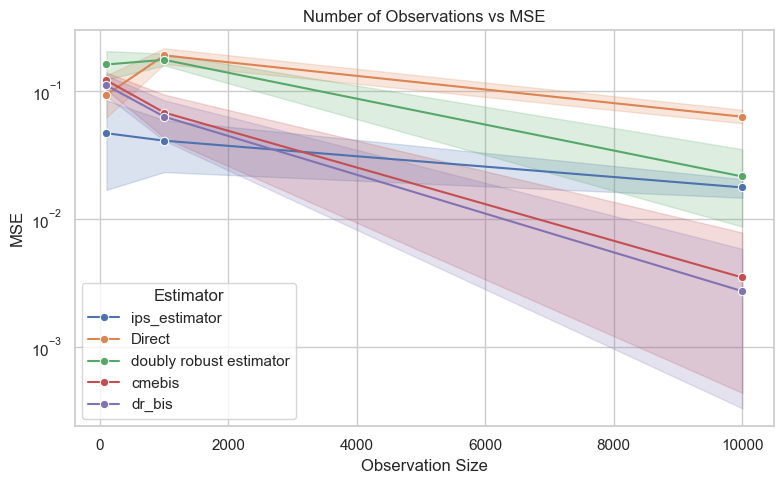

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.lineplot(
    data=full_results, x="Observation Size", y="MSE", hue="Estimator", marker="o"
)
plt.yscale("log")
plt.title("Number of Observations vs MSE")
plt.tight_layout()
plt.show()